In [13]:
import json
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

# Cluster Train Data

In [ ]:
with open("../data/LC-QuAD2.0/final_train_lcquad2.json", 'r') as f:
    train_data = json.load(f)

train_data = pd.DataFrame(train_data)

select_idx = []
ask_idx = []

for i, s in enumerate(train_data['sparql_wikidata']):
    if s.strip().lower().startswith('select'):
        select_idx.append(i)
    else:
        ask_idx.append(i)
        
df_select = train_data.iloc[select_idx]
df_ask = train_data.iloc[ask_idx]

In [15]:
len(train_data)

24180

### ASK

In [16]:
from transformers import AutoTokenizer, AutoModel
import torch

# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("BAAI/bge-m3")
model = AutoModel.from_pretrained("BAAI/bge-m3")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

from sklearn.cluster import KMeans

# Function to get embeddings
def get_embeddings(texts):
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True).to(device)  # Move inputs to GPU
    with torch.no_grad():
        outputs = model(**inputs)
    # Get embeddings from the last hidden layer
    embeddings = outputs.last_hidden_state.mean(dim=1)  # mean pooling
    return embeddings

# Data
documents = df_ask['sparql_wikidata'].tolist()

# Get embeddings for your texts
embeddings = get_embeddings(documents)

# Apply k-means clustering
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, random_state=42)
kmeans.fit(embeddings.cpu().numpy())  # Convert tensors to numpy and move back to CPU for sklearn
labels = kmeans.labels_

print(labels)


[0 1 1 ... 2 1 1]


In [17]:
df_ask['label'] = labels
df_ask = df_ask[['question', 'new_LabelsEnt', 'new_LabelsRel', 'sparql_wikidata', 'template_id', 'label']]
df_ask['label'].value_counts()

label
1    1331
0     411
2     399
Name: count, dtype: int64

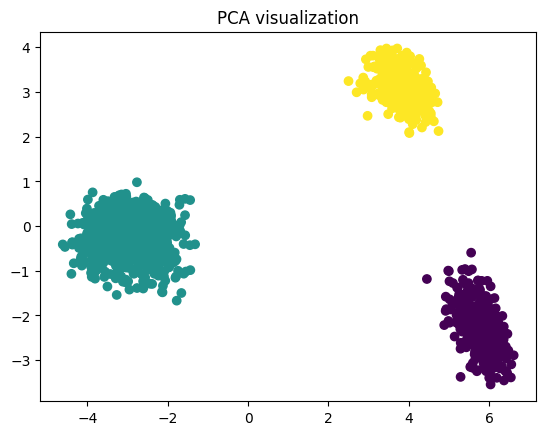

In [18]:
# PCA visualization
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce dimensions to 2D
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings.cpu().numpy())

# Plot
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels)
plt.title("PCA visualization")
plt.show()

### SELECT

In [19]:
from transformers import AutoTokenizer, AutoModel
from sklearn.cluster import KMeans
import torch
import numpy as np
from tqdm import tqdm

# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("BAAI/bge-m3")
model = AutoModel.from_pretrained("BAAI/bge-m3")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Function to get embeddings in batches
def get_embeddings_in_batches(texts, batch_size=4):
    all_embeddings = []
    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors='pt', padding=True, truncation=True).to(device)  # Move inputs to GPU
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings = outputs.last_hidden_state.mean(dim=1)  # mean pooling
        all_embeddings.append(embeddings)
    
    return torch.cat(all_embeddings, dim=0)

# Data
documents = df_select['sparql_wikidata'].tolist()

# Get embeddings for your texts in batches
embeddings = get_embeddings_in_batches(documents, batch_size=16)

100%|██████████| 1378/1378 [01:35<00:00, 14.42it/s]


In [20]:
# Apply k-means clustering
kmeans = KMeans(n_clusters=9, init='k-means++', max_iter=300, random_state=42)
kmeans.fit(embeddings.cpu().numpy())  # Move to CPU and convert tensors to numpy for sklearn
labels = kmeans.labels_

print(labels)

[4 1 1 ... 3 1 4]


In [21]:
df_select['label'] = labels
df_select = df_select[['question', 'new_LabelsEnt', 'new_LabelsRel', 'sparql_wikidata', 'template_id', 'label']]
df_select['label'].value_counts()

label
1    4975
7    4401
3    3220
4    3098
5    2128
6    1555
8    1142
0     921
2     599
Name: count, dtype: int64

In [22]:
id = 7
df_select[df_select['label'] == id]['sparql_wikidata'].tolist()

["SELECT ?value WHERE { wd:Q753 p:P2102 ?s . ?s ps:P2102 ?x filter(contains(?x,'4703.0')) . ?s pq:P2077 ?value}",
 'SELECT ?value WHERE { wd:Q36949 p:P551 ?s . ?s ps:P551 wd:Q3708911 . ?s pq:P585 ?value}',
 'SELECT ?value WHERE { wd:Q1371154 p:P166 ?s . ?s ps:P166 wd:Q7589655 . ?s pq:P585 ?value}',
 'SELECT ?value WHERE { wd:Q5593 p:P451 ?s . ?s ps:P451 wd:Q453775 . ?s pq:P582 ?value}',
 'SELECT ?obj WHERE { wd:Q1166 p:P5140 ?s . ?s ps:P5140 ?obj . ?s pq:P459 wd:Q53329492 }',
 'SELECT ?value WHERE { wd:Q510523 p:P69 ?s . ?s ps:P69 wd:Q2096836 . ?s pq:P580 ?value}',
 "SELECT ?value WHERE { wd:Q811 p:P1082 ?s . ?s ps:P1082 ?x filter(contains(?x,'3.87732e+06')) . ?s pq:P585 ?value}",
 'SELECT ?value WHERE { wd:Q1151926 p:P166 ?s . ?s ps:P166 wd:Q7843370 . ?s pq:P585 ?value}',
 'SELECT ?value WHERE { wd:Q129092 p:P119 ?s . ?s ps:P119 wd:Q1092107 . ?s pq:P373 ?value}',
 'SELECT ?obj WHERE { wd:Q1643 p:P1082 ?s . ?s ps:P1082 ?obj . ?s pq:P459 wd:Q39825 }',
 'SELECT ?value1 ?obj WHERE { wd:Q1

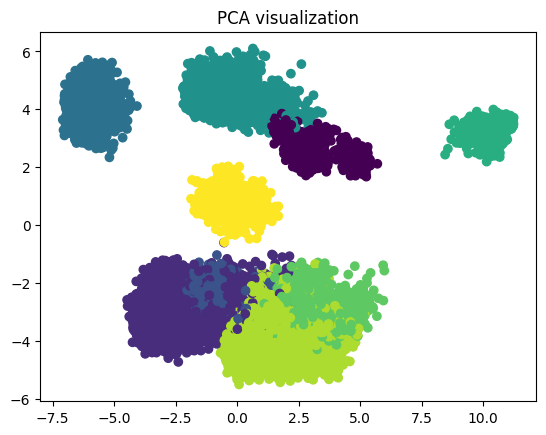

In [23]:
# PCA visualization
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce dimensions to 2D
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings.cpu().numpy())

# Plot
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels)
plt.title("PCA visualization")
plt.show()

  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:13<03:25, 13.69s/it]

For n_clusters = 5, the silhouette score is 0.2521


 12%|█▎        | 2/16 [00:27<03:16, 14.03s/it]

For n_clusters = 6, the silhouette score is 0.2669


 19%|█▉        | 3/16 [00:43<03:13, 14.88s/it]

For n_clusters = 7, the silhouette score is 0.2894


 25%|██▌       | 4/16 [00:59<03:04, 15.36s/it]

For n_clusters = 8, the silhouette score is 0.2895


 31%|███▏      | 5/16 [01:17<02:57, 16.16s/it]

For n_clusters = 9, the silhouette score is 0.2886


 38%|███▊      | 6/16 [01:34<02:43, 16.39s/it]

For n_clusters = 10, the silhouette score is 0.2627


 44%|████▍     | 7/16 [01:53<02:35, 17.28s/it]

For n_clusters = 11, the silhouette score is 0.2630


 50%|█████     | 8/16 [02:13<02:24, 18.08s/it]

For n_clusters = 12, the silhouette score is 0.2120


 56%|█████▋    | 9/16 [02:34<02:12, 18.99s/it]

For n_clusters = 13, the silhouette score is 0.2089


 62%|██████▎   | 10/16 [02:56<02:00, 20.07s/it]

For n_clusters = 14, the silhouette score is 0.2067


 69%|██████▉   | 11/16 [03:19<01:44, 20.91s/it]

For n_clusters = 15, the silhouette score is 0.1679


 75%|███████▌  | 12/16 [03:43<01:27, 21.89s/it]

For n_clusters = 16, the silhouette score is 0.2005


 81%|████████▏ | 13/16 [04:08<01:08, 22.81s/it]

For n_clusters = 17, the silhouette score is 0.1924


 88%|████████▊ | 14/16 [04:33<00:46, 23.49s/it]

For n_clusters = 18, the silhouette score is 0.1673


 94%|█████████▍| 15/16 [05:01<00:24, 24.91s/it]

For n_clusters = 19, the silhouette score is 0.1634


100%|██████████| 16/16 [05:30<00:00, 20.67s/it]

For n_clusters = 20, the silhouette score is 0.1644


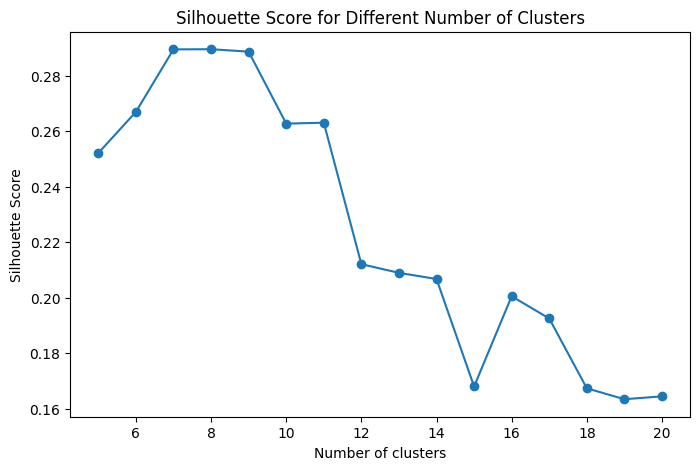

Optimal number of clusters: 8


In [24]:
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate silhouette scores for different numbers of clusters
def find_optimal_clusters(embeddings, min_clusters, max_clusters):
    silhouette_scores = []
    for n_clusters in tqdm(range(min_clusters, max_clusters + 1)):
        kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, random_state=42)
        cluster_labels = kmeans.fit_predict(embeddings.cpu().numpy())  # Use predict to get labels
        silhouette_avg = silhouette_score(embeddings.cpu().numpy(), cluster_labels)
        silhouette_scores.append(silhouette_avg)
        print(f"For n_clusters = {n_clusters}, the silhouette score is {silhouette_avg:.4f}")
    
    # Plotting silhouette scores for each cluster
    plt.figure(figsize=(8, 5))
    plt.plot(range(min_clusters, max_clusters + 1), silhouette_scores, marker='o')
    plt.title("Silhouette Score for Different Number of Clusters")
    plt.xlabel("Number of clusters")
    plt.ylabel("Silhouette Score")
    plt.show()

    # Find the optimal number of clusters (the one with the highest silhouette score)
    optimal_clusters = np.argmax(silhouette_scores) + min_clusters
    print(f"Optimal number of clusters: {optimal_clusters}")
    return optimal_clusters

# Find the optimal number of clusters using silhouette score
optimal_n_clusters = find_optimal_clusters(embeddings, min_clusters=5, max_clusters=20)


### Label 7

In [25]:
from transformers import AutoTokenizer, AutoModel
from sklearn.cluster import KMeans
import torch
import numpy as np
from tqdm import tqdm

df_select_7 = df_select[df_select['label'] == 7]

# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("BAAI/bge-m3")
model = AutoModel.from_pretrained("BAAI/bge-m3")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Function to get embeddings in batches
def get_embeddings_in_batches(texts, batch_size=16):
    all_embeddings = []
    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors='pt', padding=True, truncation=True).to(device)  # Move inputs to GPU
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings = outputs.last_hidden_state.mean(dim=1)  # mean pooling
        all_embeddings.append(embeddings)
    
    return torch.cat(all_embeddings, dim=0)

# Data
documents = df_select_7['sparql_wikidata'].tolist()

# Get embeddings for your texts in batches
embeddings_7 = get_embeddings_in_batches(documents, batch_size=16)

100%|██████████| 276/276 [00:13<00:00, 20.13it/s]


In [26]:
# Apply k-means clustering
kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=300, random_state=42)
kmeans.fit(embeddings_7.cpu().numpy())  # Move to CPU and convert tensors to numpy for sklearn
labels = kmeans.labels_

print(labels)

[0 1 1 ... 1 1 1]


In [27]:
df_select_7['label'] = labels
df_select_7 = df_select_7[['question', 'new_LabelsEnt', 'new_LabelsRel', 'sparql_wikidata', 'template_id', 'label']]
df_select_7['label'].value_counts()

label
1    3423
0     978
Name: count, dtype: int64

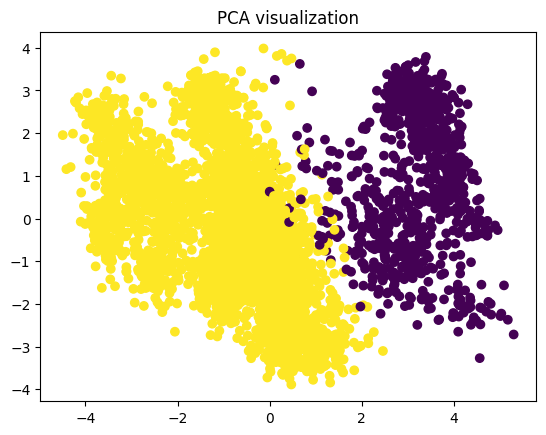

In [28]:
# PCA visualization
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce dimensions to 2D
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings_7.cpu().numpy())

# Plot
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels)
plt.title("PCA visualization")
plt.show()

In [29]:
df_select['label'].value_counts()

label
1    4975
7    4401
3    3220
4    3098
5    2128
6    1555
8    1142
0     921
2     599
Name: count, dtype: int64

In [30]:
# final label
df_select = df_select[df_select['label'] != 7]
df_select_7['label'] = df_select_7['label'].map({0: 7, 1: 9})
df_ask['label'] = df_ask['label'].map({0: 10, 1: 11, 2: 12})

df_final = pd.concat([df_select, df_select_7, df_ask])
df_final.head()

,question,new_LabelsEnt,new_LabelsRel,sparql_wikidata,template_id,label
0,What periodical literature does Delta Air Line...,"[Delta Air Lines: wd:Q188920, periodical: wd:Q...","[house publication: wdt:P2813, instance of: wd...",select distinct ?obj where { wd:Q188920 wdt:P2...,1,4
1,Who is the child of Ranavalona I's husband?,[Ranavalona I of Madagascar: wd:Q169794],"[spouse: wdt:P26, father: wdt:P22]",SELECT ?answer WHERE { wd:Q169794 wdt:P26 ?X ....,5,1
3,What is the pre-requisite of phase matter of G...,[Galinstan: wd:Q675176],"[phase of matter: wdt:P515, followed by: wdt:P...",SELECT ?answer WHERE { wd:Q675176 wdt:P515 ?X ...,2,1
4,Which is the operating income for Qantas?,[Qantas: wd:Q32491],[operating income: wdt:P3362],select distinct ?answer where { wd:Q32491 wdt:...,1.1,3
5,which cola starts with the letter p,[cola: wd:Q134041],[instance of: wdt:P31],SELECT DISTINCT ?sbj ?sbj_label WHERE { ?sbj w...,2,5


In [ ]:
df_final.to_csv('../data/LC-QuAD2.0/final_train_lcquad2_cluster.csv', index=False)

In [ ]:
final_df = pd.read_csv('../data/LC-QuAD2.0/final_train_lcquad2_cluster.csv')
final_df['label'].value_counts()

label
1     4975
9     3423
3     3220
4     3098
5     2128
6     1555
11    1331
8     1142
7      978
0      921
2      599
10     411
12     399
Name: count, dtype: int64

---

# Cluster Test Data

In [1]:
import pandas as pd
import scipy
from sentence_transformers import SentenceTransformer, util
import pickle
import torch
from sklearn.model_selection import train_test_split
import json

/home/xogns5037/.conda/envs/sparqlgen/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
train_data = pd.read_csv('../data/LC-QuAD2.0/final_train_lcquad2_cluster.csv')

In [ ]:
import pickle
from tqdm import tqdm
from FlagEmbedding import BGEM3FlagModel

# Load model
model = BGEM3FlagModel('BAAI/bge-m3', use_fp16=True)

# Initialize an empty dictionary to store embeddings
embedding_space = {}

# Iterate over the dataset
for i in tqdm(range(len(train_data))):
    s = str(train_data.iloc[i]['sparql_wikidata'])  # SPARQL query
    l = str(train_data.iloc[i]['label'])  # Cluster label
    
    # Create a unique key by concatenating the fields with tab delimiters
    key = l + '\t' + s
    
    # Compute the embedding for the question and store it in the dictionary
    embedding_space[key] = model.encode(s)['dense_vecs']

# Save the embedding space dictionary as a pickle file
with open('../data/embedding/base/train_question_embedding.pkl', 'wb') as f:
    pickle.dump(embedding_space, f)

print("Embeddings saved successfully!")

100%|██████████| 24180/24180 [05:50<00:00, 69.03it/s]


Embeddings saved successfully!


In [ ]:
with open('../data/embedding/base/train_question_embedding.pkl', 'rb') as f:
    embedding_space = pickle.load(f)

In [10]:
from sklearn.metrics.pairwise import cosine_similarity

def search(query, top_k=3):
    
    # query를 임베딩
    query_embedding = model.encode(query)['dense_vecs']
    
    # 유사도를 저장할 리스트
    similarities = []

    # 각 embedding space에서 query와의 유사도 계산
    for key, embedding in embedding_space.items():
        # 코사인 유사도를 계산
        sim = cosine_similarity(query_embedding.reshape(1, -1), embedding.reshape(1, -1))[0][0]
        similarities.append((key, sim))
    
    # 유사도 기준으로 상위 top_k개의 결과 정렬
    similarities = sorted(similarities, key=lambda x: x[1], reverse=True)[:top_k]

    return similarities

In [11]:
query = "SELECT DISTINCT ?sbj ?sbj_label WHERE { ?sbj wdt:P31 wd:Q11514315 . ?sbj wdt:P2348 wd:Q334845 . ?sbj rdfs:label ?sbj_label . FILTER(CONTAINS(lcase(?sbj_label), 'period')) . FILTER (lang(?sbj_label) = 'en') } LIMIT 25"
sim_query = search(query)[0][0]
x = sim_query.split('\t')
print(x[0])
print(x[1])

5
SELECT DISTINCT ?sbj ?sbj_label WHERE { ?sbj wdt:P31 wd:Q290178 . ?sbj rdfs:label ?sbj_label . FILTER(CONTAINS(lcase(?sbj_label), 'period')) . FILTER (lang(?sbj_label) = 'en') } LIMIT 25


In [ ]:
from tqdm import tqdm

with open('../data/LC-QuAD2.0/final_test_lcquad2.json', 'r') as f:
    test_data = json.load(f)
    
test_data = pd.DataFrame(test_data)

labels = []

for i in tqdm(range(len(test_data))):
    s = test_data.iloc[i]['sparql_wikidata']
    x = search(s)[0][0]
    x = x.split('\n')[0]
    labels.append(x)
    
test_data['label'] = labels
  

In [ ]:
test_data.to_csv('../data/LC-QuAD2.0/final_test_lcquad2_cluster.csv', index=False)

---

# Oversampling

In [ ]:
train_datasets = pd.read_csv('../data/LC-QuAD2.0/final_train_lcquad2_cluster.csv').dropna()

train_sents = train_datasets['question'].tolist()
train_labels = train_datasets['label'].tolist()

print(set(train_labels))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}


In [3]:
train_datasets['label'].value_counts()

label
1     4975
9     3385
3     3220
4     3040
5     2127
6     1548
11    1331
8     1142
7      969
0      921
2      599
10     411
12     399
Name: count, dtype: int64

In [4]:
import numpy as np
from imblearn.over_sampling import RandomOverSampler

# 1D 리스트를 2D 배열로 변환
train_sents_reshaped = np.array(train_sents).reshape(-1, 1)

# Oversampling 적용
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(train_sents_reshaped, train_labels)

# X_resampled을 다시 1D 리스트로 변환
X_resampled = X_resampled.ravel().tolist()

In [5]:
X_resampled

['What periodical literature does Delta Air Lines use as a moutpiece?',
 "Who is the child of Ranavalona I's husband?",
 'What is the pre-requisite of phase matter of Galinstan?',
 'Which is the operating income for Qantas?',
 'which cola starts with the letter p',
 'What is the complete list of records released by Jerry Lee Lewis?',
 "What's Mary Lou Retton's International Olympic Committee athlete ID.",
 "Who won the prize at the sequel of the 1885 Wimbledon Championships- Gentlemen's Singles?",
 "Tell me the female beauty pageant that operates in all countries and contains the word model in it's name?",
 'When position did Angela Merkel hold on November 10, 1994?',
 'On 0-0-2007, what is the populaton of Spokane?',
 'What essential medicine is needed to treat leprosy?',
 'Which is HanCinema person ID for Zhang Ziyi?',
 'After what is Marathon named and what is the current record?',
 'Who Sleepwalking succeeded in playing Sleepwalking?',
 'What did Clifton Chenier get nominated for i

In [6]:
from collections import Counter

print('Original dataset shape %s' % Counter(train_labels))
print('Resampled dataset shape %s' % Counter(y_resampled))

Original dataset shape Counter({1: 4975, 9: 3385, 3: 3220, 4: 3040, 5: 2127, 6: 1548, 11: 1331, 8: 1142, 7: 969, 0: 921, 2: 599, 10: 411, 12: 399})
Resampled dataset shape Counter({4: 4975, 1: 4975, 3: 4975, 5: 4975, 6: 4975, 2: 4975, 0: 4975, 8: 4975, 7: 4975, 9: 4975, 10: 4975, 11: 4975, 12: 4975})


In [ ]:
train_over = pd.DataFrame({'question': X_resampled, 'label': y_resampled})

In [ ]:
# Classification Model Train Data
train_over = pd.read_csv('../data/LC-QuAD2.0/final_train_lcquad2_cluster_over.csv')
train_over['label'].value_counts()

label
4     4975
1     4975
3     4975
5     4975
6     4975
2     4975
0     4975
8     4975
7     4975
9     4975
10    4975
11    4975
12    4975
Name: count, dtype: int64

In [14]:
len(train_over)

64675

In [ ]:
from tqdm import tqdm
import json
import pandas as pd

with open('../data/LC-QuAD2.0/final_train_lcquad2.json', 'r') as f:
    data = json.load(f)    
mapping_df = pd.DataFrame(data)

train_over = pd.read_csv('../data/LC-QuAD2.0/final_train_lcquad2_cluster_over.csv')

new_LabelsEnt = []
new_LabelsRel = []
sparql_wikidata = []

for i in tqdm(range(len(train_over))):
    question = train_over.loc[i, 'question']
    label = train_over.loc[i, 'label']
    
    entity = mapping_df[mapping_df['question'] == question]['new_LabelsEnt'].values[0]
    relation = mapping_df[mapping_df['question'] == question]['new_LabelsRel'].values[0]
    sparql = mapping_df[mapping_df['question'] == question]['sparql_wikidata'].values[0]
    
    if len(entity) == 0:
        entity = []
    
    if len(relation) == 0:
        relation = []
    
    new_LabelsEnt.append(entity)
    new_LabelsRel.append(relation)
    sparql_wikidata.append(sparql)
    
train_over['new_LabelsEnt'] = new_LabelsEnt
train_over['new_LabelsRel'] = new_LabelsRel
train_over['sparql_wikidata'] = sparql_wikidata

train_over


100%|██████████| 64675/64675 [05:03<00:00, 212.98it/s]


,question,label,new_LabelsEnt,new_LabelsRel,sparql_wikidata
0,What periodical literature does Delta Air Line...,4,"[Delta Air Lines: wd:Q188920, periodical: wd:Q...","[house publication: wdt:P2813, instance of: wd...",select distinct ?obj where { wd:Q188920 wdt:P2...
1,Who is the child of Ranavalona I's husband?,1,[Ranavalona I of Madagascar: wd:Q169794],"[spouse: wdt:P26, father: wdt:P22]",SELECT ?answer WHERE { wd:Q169794 wdt:P26 ?X ....
2,What is the pre-requisite of phase matter of G...,1,[Galinstan: wd:Q675176],"[phase of matter: wdt:P515, followed by: wdt:P...",SELECT ?answer WHERE { wd:Q675176 wdt:P515 ?X ...
3,Which is the operating income for Qantas?,3,[Qantas: wd:Q32491],[operating income: wdt:P3362],select distinct ?answer where { wd:Q32491 wdt:...
4,which cola starts with the letter p,5,[cola: wd:Q134041],[instance of: wdt:P31],SELECT DISTINCT ?sbj ?sbj_label WHERE { ?sbj w...
...,...,...,...,...,...
64670,Was FUJIC influenced by computers?,12,"[computer: wd:Q68, FUJIC: wd:Q5427274]",[influenced by: wdt:P737],ASK WHERE { wd:Q68 wdt:P737 wd:Q5427274 }
64671,Is Venom the partner of Spider Man?,12,"[Spider-Man: wd:Q79037, Venom: wd:Q1621261]",[unmarried partner: wdt:P451],ASK WHERE { wd:Q79037 wdt:P451 wd:Q1621261 }
64672,Is it true that Hugh Jackman was educated at W...,12,"[Hugh Jackman: wd:Q129591, Western Sydney Univ...",[educated at: wdt:P69],ASK WHERE { wd:Q129591 wdt:P69 wd:Q1141452 }
64673,Is William Wilde the father of Oscar Wilde?,12,"[Oscar Wilde: wd:Q30875, William Wilde: wd:Q25...",[father: wdt:P22],ASK WHERE { wd:Q30875 wdt:P22 wd:Q2540254 }


In [ ]:
# LLM Train Data
train_over.to_csv('../data/LC-QuAD2.0/final_train_lcquad2_cluster_over_rait.csv', index=False)